# MarlimR3D -- Acquisition parameters


## Acquisition parameters

- 500 receivers located on the irregular seafloor;
- for each receiver, sources were located along 45 towlines with a spacing of 1 km; 25 east-west, 20 north-south;
- source: azimuth and dip 0°, dipole length 278 m, dipole strength 1250 A, 50 m above sea floor.


![survey](../figures/survey.png)


#### References TODO: Replace by full references
- http://www.scielo.br/scielo.php?script=sci_arttext&pid=S2317-48892017000400633  # Model
- https://library.seg.org/doi/full/10.1190/geo2018-0452.1                         # Data
- https://zenodo.org/record/400233   # Model
- https://zenodo.org/record/1256787  # Data
- https://zenodo.org/record/1807135  # Data With Noise

In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

## Load the two station from Correa and Menezes, 2019, GEO, Figure 4

In [2]:
def get_data(name, path='../DATA/'):
    """Load data, real to complex."""
    d = xarray.load_dataset(path+name)
    data = d['emf'][::2, :] + 1j*d['emf'][1::2, :]
    return data, d

# Load noise data
datemf1, data1 = get_data('EW_Survey/AddedNoise/mr3d_04Tx013a_04Rx251a_addednoise.nc')
datemf2, data2 = get_data('EW_Survey/AddedNoise/mr3d_04Tx014a_04Rx251a_addednoise.nc')

# Load clean data
datemf3, data3 = get_data('EW_nonoise/Synthetic/mr3d_04Tx013a_04Rx251a_windowed.nc')
datemf4, data4 = get_data('EW_nonoise/Synthetic/mr3d_04Tx014a_04Rx251a_windowed.nc')

# Get E{x;y;z} components
components = data1['emf'].emf_fieldtype.split()[:3]
print(f"Components: {components}")

# Get frequencies
frequencies = data1.freqs
print(f"Frequencies (Hz): {frequencies}")

Components: ['Ex', 'Ey', 'Ez']
Frequencies (Hz): [0.125 0.25  0.5   0.75  1.    1.25 ]


## Save coordinates

In [6]:
noff = datemf1[:, 0].size//6
src1 = data1['srcpos'][:2*noff:2, :3].values

noff = datemf2[:, 0].size//6
src2 = data2['srcpos'][:2*noff:2, :3].values

rec = np.array([data1.x_r, data1.y_r, data1.z_r])

np.savez('../data/marlimFig4Coord', src_in=src1, src_br=src2, rec=rec)

In [4]:
# They can be loaded like this
coords = np.load('../data/marlimFig4Coord.npz')
src_in, src_br, rec = coords['src_in'], coords['src_br'], coords['rec']

## With noise, same as in paper

In [5]:
def plot_it(datemf1, datemf2):

    # Line styles
    ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

    plt.figure(figsize=(12, 12))

    # Loop over Inline/Broadside
    for iii in range(2):

        # Number of offsets
        noff = [datemf1[:, 0].size//6, datemf2[:, 0].size//6][iii]

        # Get x-coordinates
        dat = [data1, data2][iii]
        xcord = dat['srcpos'][:, 0][:2*noff:2]-dat.x_r

        # We mask the stations closer than 750 meters to the source
        mask = abs(xcord) > 750

        # Take absolute value
        data = np.abs([datemf1, datemf2][iii])

        # Loop over components Ex, Ey, Ez
        for ii, comp in enumerate(components):

            plt.subplot(3, 2, 2*ii+1+iii)
            plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

            # Loop over frequencies
            for i, freq in enumerate(frequencies):

                # Plot this component/frequency
                plt.plot(xcord[mask], data[i*noff:(i+1)*noff, ii][mask],
                         ls[i], mec='k', mew=0.5, ms=4, label=f"{freq:4.3f}")

            plt.legend(title='f (Hz)')
            plt.grid('on')
            plt.yscale('log')

    plt.tight_layout()
    plt.show()

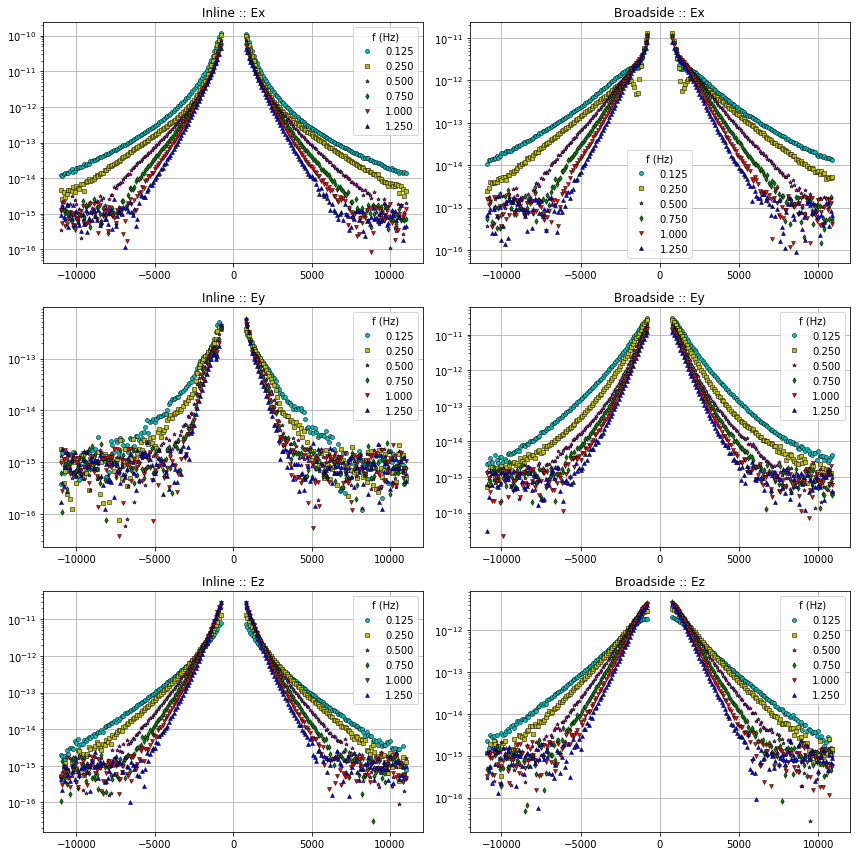

In [6]:
plot_it(datemf1, datemf2)

**NOTE:** In the paper, subfigures (e) and (f) are switched (no idea why).

## Without noise, what we want to reproduce

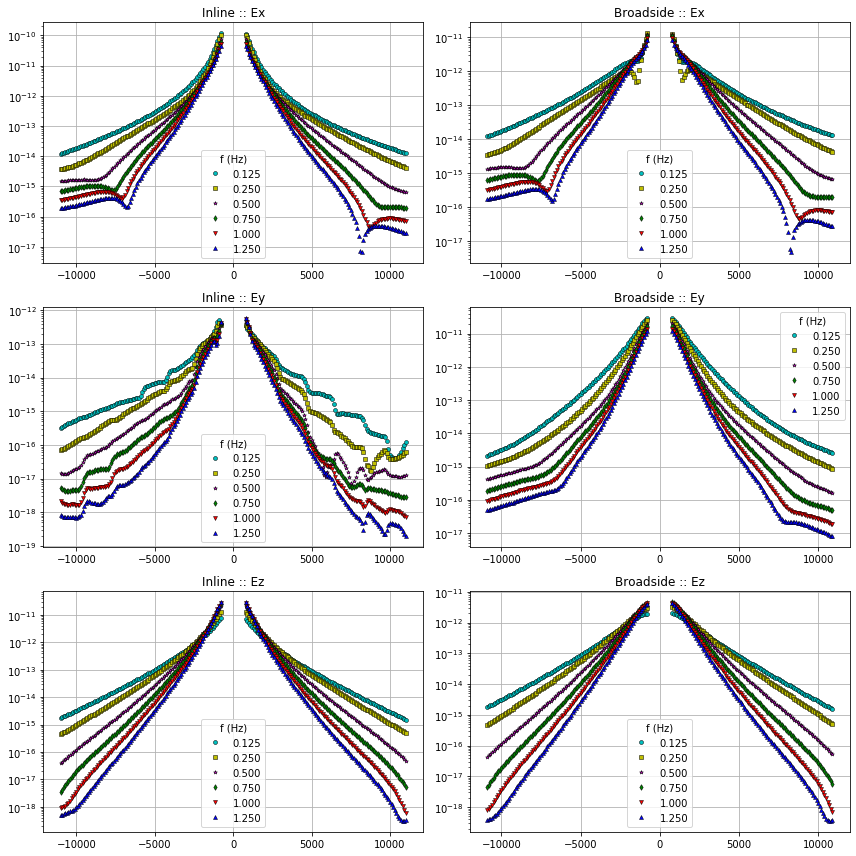

In [7]:
plot_it(datemf3, datemf4)

## Load all data (assuming there in the folder `../DATA`)

In [8]:
files1 = !ls ../DATA/EW_nonoise/Synthetic/*.nc

# There are 25x20=500 receivers
coords = np.zeros((500, 5))

done = np.zeros(500)
for i, file in enumerate(files1):
    ni = int(file.split('_')[-2][4:-1])
    if done[ni-1] != 1:
        out = xarray.load_dataset(file)
        coords[ni-1, :] = out.x_r, out.y_r, out.z_r, out.phi, out.theta
        done[ni-1] = 1

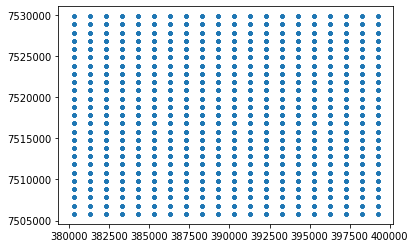

In [9]:
plt.figure()
plt.plot(coords[:, 0], coords[:, 1], '.')
plt.show()

In [10]:
import scooby
scooby.Report(xarray)

--------------------------------------------------------------------------------
  Date: Mon Dec 23 14:22:12 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.14.0 : xarray
            1.17.3 : numpy
             1.3.1 : scipy
             7.9.0 : IPython
             3.1.1 : matplotlib
             0.4.3 : scooby

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------